# NV Center in Diamond
In this tutorial we will go over the main steps of running CCE calculations for the NV center in diamond with the **PyCCE** module. Those include:

* Generating the spin bath using the `pycce.BathCell` instance.
* Setting up properties of the `pycce.Simulator` instance.
* Running the calculations with the `Simulator.compute` function.

We will computethe  Hahn-echo coherence function (with decoupling $\pi$-pulse applied) using the following available methods: 

* Conventional CCE.
* Generalized CCE (gCCE).
* gCCE with Monte-Carlo bath sampling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import pycce as pc
import ase

from mpl_toolkits import mplot3d

seed = 8805
np.random.seed(seed)
np.set_printoptions(suppress=True, precision=5)

## Generate nuclear spin bath
Building a supercell of nuclear spins from the `ase.Atoms` object.

### Build BathCell

To generate cell it from `ase.atoms` object, use classmethod `BathCell.from_ase`.

In [29]:
from ase.build import bulk

# Generate unitcell from ase
diamond = bulk('C', 'diamond', cubic=True)
diamond = pc.read_ase(diamond)

The following attributes are created with this initiallization:

* `.cell` is ndarray containing information of lattice vectors. Each **column** is a lattice vector in cartesian coordinates.
* `.atoms` is a dictionary with keys corresponding to the atom name, and each item is a list of the coordinates in cell coordinates.

In [3]:
print('Cell\n', diamond.cell)
print('\nAtoms\n', diamond.atoms)

Cell
 [[3.57 0.   0.  ]
 [0.   3.57 0.  ]
 [0.   0.   3.57]]

Atoms
 defaultdict(<class 'list'>, {'C': [array([0., 0., 0.]), array([0.25, 0.25, 0.25]), array([0. , 0.5, 0.5]), array([0.25, 0.75, 0.75]), array([0.5, 0. , 0.5]), array([0.75, 0.25, 0.75]), array([0.5, 0.5, 0. ]), array([0.75, 0.75, 0.25])]})


### Populate BathCell with isotopes

The **PyCCE** package uses EasySpin database of the concentrations of all common stable isotopes with non-zero spin, however the user can proide custom concentrations.


Use function `BathCell.add_isotopes` to add one (or several) isotopes of the element. Each isotope is initiallized with ``tuple`` containing name of the isotope and its concentration.

Name of the isotope includes the number and element symbol, provided in the `atoms` object. As an output, the `BathCell.add_isotopes` method returns view on dictionary `BathCell.isotopes` which can be modified directly. Structure of the dictionary-like object:

```
{element_1: {isotope_1: concentration, isotope_2: concentration},
 element_2: {isotope_3: concentration ...}}
```


In [4]:
# Add types of isotopes
diamond.add_isotopes(('13C', 0.011))

defaultdict(dict, {'C': {'13C': 0.011}})

Isotopes may also be directly added to `BathCell.isotopes`. For example, below we are adding an isotope without the nuclear spin:

In [5]:
diamond.isotopes['C']['14C'] = 0.001

### Set z-direction of the bath (optional)

In the `Simulator` object everything is set in $S_z$ basis. When the quantization axis of the defect does not allign with the (0, 0, 1) direction of the crystal axis, the user needs to define the axis.

If one wants to specify the complete rotation of cartesian axes, one can provide a rotation matrix to rotate the cartesian reference frame with respect to the cell coordinates by calling the `BathCell.rotate` method.

In [6]:
# set z direction of the defect
diamond.zdir = [1, 1, 1]

### Generate spin bath

To generate the spin bath, use the `BathCell.gen_supercell` method. First argument is the linear size of the supercell (minimum distance between any two faces of the supercell is equal to or larger than this parameter). Additional keyword arguments are `remove` and `add`.

`remove` takes a ``tuple`` or ``list of tuples`` as an argument. First element of each tuple is the name of the **atom** at that location, second element - coordinates in unit cell coordinates. If such atoms are found in the supercell, they are removed from it.

`add` takes a ``tuple`` or ``list of tuples`` as an argument. First element of each tuple is the name of the **isotope** at that location, second element - coordinates in unit cell coordinates.  Each of the specified isotopes will be added in the final supercell at specified locations.

In [7]:
# Add the defect. remove and add atoms at the positions (in cell coordinates) 
atoms = diamond.gen_supercell(200, remove=[('C', [0., 0, 0]),
                                           ('C', [0.5, 0.5, 0.5])],
                              add=('14N', [0.5, 0.5, 0.5]),
                              seed=seed)

/home/onizhuk/midway/codes_development/pyCCE/pycce/bath/array.py:220: UserWarning: Spin type for 14C was not provided and was not found in common isotopes.
  obj[n] = array[n]


Note, that because the `14C` isotope doesn't have a spin, **PyCCE** does not find it in common isotopes, and raises a warning. We have to provide `SpinType` for it separately, or define the properties as follows:

In [8]:
atoms['14C'].gyro = 0
atoms['14C'].spin = 0

## BathArray Structure
The bath spins are stored in the `BathArray` object - a subclass of `np.ndarray` with fixed datastructure:

* `N` field `dtype('<U16')` contains the names of bath spins.
* `xyz` field `dtype('<f8', (3,))` contains the positions of bath spins (in A).
* `A` field `dtype('<f8', (3, 3))` contains the hyperfine coupling of bath spins (in kHz).
* `Q` field `dtype('<f8', (3, 3))` contains the quadrupole tensor of bath spins (in kHz) (Relevant for spin >= 1).

All of the fields are accesible as attributes of `BathArray`.
Additionally, the subarrays of the specific spins are accessible with their name as indicated above.

Upon generation of the array from the cell, the `Q` and `A` fields are empty. The Hyperfine couplings will be automatically computed by the `Simulator` object, however the quadrupole couplings must be set by the user.

The additional attributes allow one to access `SpinType` properties:

+ `name` returns the spin name or array of spin names;
+ `spin` returns the value of the spin or array of ones;
+ `gyro` returns gyromagnetic ratios of the spins;
+ `q` returns quadrupole constants of the spins;
+ `h` returns a dictionary with user-defined additions to the Hamiltonian. 
+ `detuning` returns detunings of the spins (See definition below).

For example, below we print out the attributes of the first two spins in the `BathArray`.

In [9]:
print('Names\n', atoms[:2].N)
print('\nCoordinates\n', atoms[:2].xyz)
print('\nHyperfine tensors\n', atoms[:2].A)
print('\nQuadrupole tensors\n',atoms[:2].Q)

Names
 ['13C' '13C']

Coordinates
 [[-13.97678  -1.48178 -92.75132]
 [ 27.89939  42.17939 -45.86038]]

Hyperfine tensors
 [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]

Quadrupole tensors
 [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


The properties of spin types (gyromagnetic ratio, quadrupole moment, etc) are stored in the `BathArray.types` attribute, which is an instance of `SpinDict` containing `SpinType` classes. For most known isotopes `SpinType` can be found in the `pycce.common_isotopes` dictionary, and is set by default (including electron spin-1/2, which is denoted by setting `N = e`). The user can add additional `SpinType` objects, by calling `BathArray.add_type` method or setting elements of `SpinDict` directly. For details of the first approach see documentation of `SpinDict.add_type` method.

The direct setting of types is rather simple. The user can set elements of `SpinDict` with ``tuple``, containing:

* **(spin, gyromagnetic ratio, quadrupole moment *(optional)*, detuning *(optional)*, )** 

  **OR**
  
* **(isotope, spin, gyromagnetic ratio, quadrupole moment *(optional)*, detuning *(optional)*, )** 

where:

- **isotope** (*str*) is the name of the given spin (same one as in `N` field of `BathArray`) to define new `SpinType` object.
  The key of `SpinDict` **has** to be the correct name of the spin ("isotope" field in the tuple).
- **spin** (*float*) is the total spin of the given bath spin.
- **gyromagnetic ratio** (*float*) is the gyromagnetic ratio of the given bath spin.
- **quadrupole moment** (*float*) is the quadrupole moment of the given bath spin. Relevant only when electric field gradient are used
  to generate quadrupole couplings for spins, stored in the ``BathArray``, with ``BathArray.from_efg`` method.
- **detuning** (float) is an additional energy splitting for model spins, included as an extra $+\omega \hat S_z$ term in the Hamiltonian,
  where $\omega$ is the detuning.

Units of gyromagnetic ratio are rad / ms / G, quadrupole moments are given in barn, detunings are given in kHz.

In [10]:
# Several ways to set SpinDict elements
atoms.types['14C'] = 0, 0, 0
atoms.types['Y'] = ('Y', 0, 0, 0)
atoms.types['A'] = pc.SpinType('A', 0, 0, 0)

print(atoms.types)

SpinDict(13C: (0.5, 6.7283), 14N: (1.0, 1.9338, 0.0204), 14C: (0.0, 0.0000), ...)


## Simulator class

The parameters of the CCE simulator engine.

Main parameters to consider:

* `spin` — Either instance of the `CenterArray` or float - total spin of the central spin (assuming one central spin).

* `bath` — spin bath in any specified format. Can be either:

  - Instance of `BathArray` class;
  - `ndarray` with ``dtype([('N', np.unicode_, 16), ('xyz', np.float64, (3,))])`` containing names
    of bath spins (same ones as stored in self.ntype) and positions of the spins in angstroms;
  - The name of the `.xyz` text file containing 4 columns: name of the bath spin and xyz coordinates in A.

* `r_bath` — cutoff radius around the central spin for the bath.

* `order` — maximum size of the cluster.

* `r_dipole` — cutoff radius for the pairwise distance to consider two nuclear spins to be connected.

* `magnetic_field` — applied magnetic field. Can also be provided during the simulation run.

* `pulses` — number of pulses in Carr-Purcell-Meiboom-Gill (CPMG) sequence or the pulse sequence itself.

For the full description see the documentation of the `Simulator` object.

First we setup a "mock" instance of `Simulator` to visualize the smaller part of the bath around the central spin.

In [11]:
# Setting the runner engine
mock = pc.Simulator(spin=1, position=[0,0,0],
                    bath=atoms, r_bath=20,
                    r_dipole=6, order=3)

During the initiallization, depending on the provided keyword arguments several methods may be called:

* `Simulator.read_bath` is called if keyword `bath` is provided. It may take several additional arguments:

    * `r_bath` - cutoff distance from the qubit for the bath.
    * `skiprows` - if `bath` is provided as `.xyz` file, this argument tells how many rows to skip when reading the file.
    * `external_bath` - `BathArray` instance, which contains bath spins with pre defined hyperfines to be used.
    * `hyperfine` - defines the way to compute hyperfine couplings. If it is not given and `bath` doesn't contain any predefined hyperfines
      (`bath['A'].any() == False`) the point dipole approximation is used.
      Otherwise it can be an instance of ``pc.Cube`` object, or callable with signature ``func(coord, gyro, central_gyro)``,
      where `coord` is an array of the bath spin coordinate, gyro is the gyromagnetic ratio of bath spin,
      central_gyro is the gyromagnetic ratio of the central bath spin.
    * `types` - instance of `SpinDict` or input to create one.
    * `error_range` - maximum allowed distance between positions in `bath` and `external_bath` for two spins to be considered the same.
    * `ext_r_bath` - cutoff distance from the qubit for the `external_bath`. 
      Useful if `external_bath` has very assymetric shape and user wants to keep the precision level of the hyperfine at different distances consistent.
    * `imap` - instance of the `pc.InteractionMap` class, which contain tensor of bath spin interactions.
      If not provided, interactions between bath spins are assumed to be the same as one of point dipoles.
   
  Generates `BathArray` object with hyperfine tensors to be used in the calculation.

* `Simulator.generate_clusters` is called if `order` and `r_dipole` are provided.
  It produces `dict` object, which contains the indexes of the bath spins in the clusters.
  
  We implemented the following procedure to determine the clusters:
  
  Each bath spin $i$ forms a cluster of one. 
  Bath spins $i$ and $j$ form cluster of two if there is an edge between them (distance $d_{ij} \le$ `r_dipole`).
  Bath spins $i$, $j$, and $k$ form a  cluster of three if enough edges connect them (e.g., there are two edges $ij$ and $jk$) and so on.
  In general, we assume that spins $\{i..n\}$ form clusters if they form a connected graph.
  Only clusters up to the size indicated by the `order` parameter (equal to CCE order) are included.
 

We use `matplotlib` to visualize the spatial distribution of the spin bath. The grey lines show connected pairs of nuclear spins, red dashed lines show clusters of three. You can try to increase `r_dipole`, `r_bath` parameters, or increase `order` and visuallize.

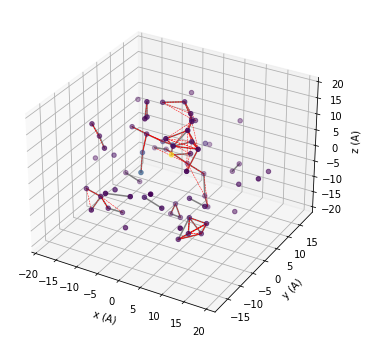

In [12]:
# add 3D axis
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# We want to visualize the smaller bath
data = mock.bath

# First plot the positions of the bath 
colors = np.abs(data.A[:,2,2]/data.A[:,2,2].max())
ax.scatter3D(data.x, data.y, data.z, c=colors, cmap='viridis');
# Plot all pairs of nuclear spins, which are contained
# in the calc.clusters dictionary under they key 2
for c in mock.clusters[2]:
    ax.plot3D(data.x[c], data.y[c], data.z[c], color='grey')
# Plot all triplets of nuclear spins, which are contained
# in the calc.clusters dictionary under they key 3
for c in mock.clusters[3]:
    ax.plot3D(data.x[c], data.y[c], data.z[c], color='red', ls='--', lw=0.5)

ax.set(xlabel='x (A)', ylabel='y (A)', zlabel='z (A)');

Now we setup `Simulator` object for the actual simulation. 

In [13]:
# Parameters of CCE calculations engine

# Order of CCE aproximation
order = 2
# Bath cutoff radius
r_bath = 40  # in A
# Cluster cutoff radius
r_dipole = 8  # in A


we will use the ``CenterArray`` object to store the properties of the central spin,
however for simple usecases one can provide the corresponding keywords to the `Simulator` object directly.

In [14]:
# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 0, 1]; beta = [0, 1, 0]
# ZFS Parametters of NV center in diamond
D = 2.88 * 1e6 # in kHz
E = 0 # in kHz
nv = pc.CenterArray(spin=1, position=position, D=D, E=E, alpha=alpha, beta=beta)

The code already knows the properties of the most common nuclear spins and of elecron spin (accessible under the name `'e'`), however the user can provide their own by calling `BathArray.add_type` method. The way to initiallize `SpinType` objects is the same as in  `SpinDict` above.

In [15]:
# The code already knows most exsiting isotopes.
#              Bath spin types
#              name    spin    gyro       quadrupole (for s>1/2)
spin_types = [('14N',  1,      1.9338,    20.44),
              ('13C',  1 / 2,  6.72828),
              ('29Si', 1 / 2, -5.3188),]
atoms.add_type(*spin_types)

### Setting the `Simulator` object
All of the kwargs can be provided at the moment of creation. If all of the kwargs are provided, several methods of the `Simulator` class are called:

* `Simulator.read_bath`;
* `Simulator.generate_clusters`.

The details are available in the `Simulator` methods description.

In [16]:
# Setting the runner engine
calc = pc.Simulator(spin=nv, bath=atoms,
                    r_bath=r_bath, r_dipole=r_dipole, order=order)

Taking advantage of subclassing `np.ndarray` we can change *in situ* the quadrupole tensor of the Nitrogen nuclear spin.

In [17]:
nspin = calc.bath
# Set model quadrupole tensor at N atom
quad = np.asarray([[-2.5, 0, 0],
                   [0, -2.5, 0],
                   [0, 0,  5.0]]) * 1e3 * 2 * np.pi

nspin['Q'][nspin['N'] == '14N'] = quad

Note, that we need to apply the boolean mask **second** because of how structured arrays work.

### Compute coherence function with conventional CCE

The general interface to compute any property with PyCCE is implemented through the `Simulator.compute` method. It takes two keyword arguments to determine which quantity to compute and how:

* `method` can take 'cce' or 'gcce' values, and determines which method to use - conventional or generalized CCE.
* `quantity` can take 'coherence' or 'noise' values, and determines which quantity to compute - coherence function
  or autocorrelation function of the noise.

Each of the methods can be performed with Monte Carlo bath state sampling (if `nbstates` keyword is non zero) and with interlaced averaging (If `interlaced` keyword is set to `True`).

In the first example we use the conventional CCE method without Monte Carlo bath state sampling. In the conventional CCE method the Hamiltonian is projected on the qubit levels, and the coherence is computed from the overlap of the bath evolution, entangled with two different qubit states.

The conventional CCE requires one argument:

* `timespace` — time points at which the coherence function is computed.

Additionally, one can provide the following arguments now, instead of when initiallizing ``Simulator`` object:

* `pulses` — number of pulses in CPMG sequence (0 - FID, 1 - HE etc., default 0) or explicit sequence of pulses as `Sequence` class instance.
* `mangetic_field` — magnetic field along z-axis or vector of the magnetic field. Default (0, 0, 0).

In [30]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms
# Number of pulses in CPMG seq (0 = FID, 1 = HE)
n = 1
# Mag. Field (Bx By Bz)
b = np.array([0, 0, 500])  # in G

l_conv = calc.compute(time_space, pulses=n, magnetic_field=b, 
                      method='cce', quantity='coherence', as_delay=False)

In [19]:
%%timeit
calc.compute(time_space, pulses=n, magnetic_field=b,
             method='cce', quantity='coherence', as_delay=False)

699 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Generalized CCE (gCCE)

In contrast to the conventional CCE method, in generalized CCE arpproach each cluster includes the central spin explicitly.

`Simulator` can take `pulses` argument as an actual pulse sequence with an iterable of `Pulse` objects.

For example:

~~~
p1 = pc.Pulse('x', np.pi)
p2 = pc.Pulse('y', np.pi)
seq = [p1, p2, p1, p2]
~~~

`seq` will define XY-4 pulse sequence.

An integer number to define the number of pulses  is also accepted as in the case of conventional CCE. If the integer is provided, the code assumes the CPMG sequence.

In [20]:
# Hahn-echo pulse sequence
pulse_sequence = [pc.Pulse('x', np.pi)]

# Calculate coherence function
l_generatilze = calc.compute(time_space, magnetic_field=b,
                             pulses=pulse_sequence,
                             method='gcce', quantity='coherence')

In [21]:
%%timeit
calc.compute(time_space, magnetic_field=b,
             pulses=pulse_sequence,
             method='gcce',
             quantity='coherence')

1.88 s ± 8.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### gCCE with random sampling of bath states

Using this approach, one may carry out generalized CCE calculations for the set of random bath states. This functionality can be turned on by by setting the keyword argument `nbstates` to a number of bath states to sample over. Recommended number of bath states is above 100, but the convergence should be checked for each system. Note, that this computation is roughly `nbstates` times longer than an equivalent generalized CCE calculation, as it computes everything `nbstates` times.

For details see `help(calc.compute)`.

In [22]:
# Number of random bath states to sample over
n_bath_states = 20

# Calculate coherence function
l_gcce = calc.compute(time_space, magnetic_field=b,
                      pulses=pulse_sequence,
                      nbstates=n_bath_states,
                      method='gcce', quantity='coherence', seed=seed)

In [23]:
%%timeit
n_bath_states = 5
calc.compute(time_space, magnetic_field=b,
             pulses=pulse_sequence,
             nbstates=n_bath_states,
             method='gcce', quantity='coherence', seed=seed)

11.7 s ± 409 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Take a look at the results of three different methods, and check that they produce similar coherence decay. Note that the results obtained using gCCE with bath states sampling deviates from other ones (generalized and conventional CCE), as the chosen number of states (20) is not enough to converge.

Text(0, 0.5, 'Coherence')

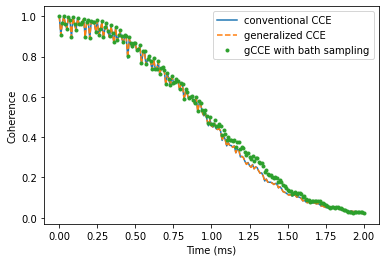

In [24]:
plt.plot(time_space, l_conv.real,
         label='conventional CCE')
plt.plot(time_space, l_generatilze.real,
         label='generalized CCE', ls='--')
plt.plot(time_space, l_gcce.real,
         label='gCCE with bath sampling', ls='', marker='.')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Coherence')

### Convergence parameters
Having confirmed that all methods produce the same results, we check the convergence of the conventional CCE with respect to `order`, `r_bath`, `r_dipole` parameters of the `Simulator` object.

First, define all of the parameters.

In [25]:
parameters = dict(
    order=2, # CCE order
    r_bath=40,  # Size of the bath in A
    r_dipole=8,  # Cutoff of pairwise clusters in A
    position=[0, 0, 0], # Position of central Spin
    alpha=[0, 0, 1],
    beta=[0, 1, 0],
    pulses = 1, # N pulses in CPMG sequence
    magnetic_field=[0,0,500]
) # Qubit levels)

time_space = np.linspace(0, 2, 201)  # Time points in ms

We can define a little helper function to streamline the process. Note that resetting the parameters automatically recomputes the properties of the bath.

In [26]:
def runner(variable, values):
    invalue = parameters[variable]
    calc = pc.Simulator(spin=1, bath=atoms, **parameters)
    ls = []

    for v in values:
        setattr(calc, variable, v)
        l = calc.compute(time_space, method='cce',
                         quantity='coherence')

        ls.append(l.real)

    parameters[variable] = invalue
    ls = pd.DataFrame(ls, columns=time_space, index=values).T
    return ls

Now we can compute the coherence function at different values of the parameters:

In [27]:
orders = runner('order', [1, 2, 3, 4])
rbs = runner('r_bath', [20, 30, 40, 50, 60])
rds = runner('r_dipole', [4, 6, 8, 10])

We can visualize the convergence of the coherence function with respect to different parameters:

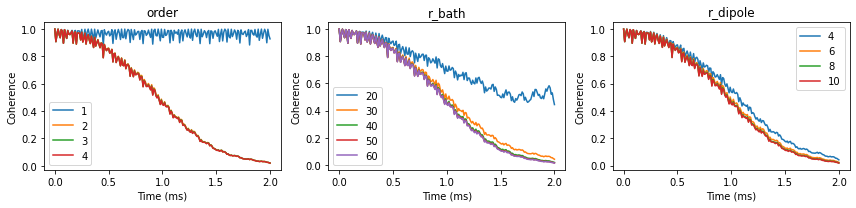

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
orders.plot(ax=axes[0], title='order')
rbs.plot(ax=axes[1], title='r_bath')
rds.plot(ax=axes[2], title='r_dipole')
for ax in axes:
    ax.set(xlabel='Time (ms)', ylabel='Coherence')
fig.tight_layout()